# Continuous Optimization

In this tutorial we will go into some of the details of optimizing a Euclidean landscape in continuous space. As an extra, we will optimize a landscape with two different point types to show the way our software handles movement heterogeneity.

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MGSurvE as srv
%matplotlib inline
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('Continuous_GA', './out/')

We'll generate a 10 by 10 regular grid landscape with the point-type assigned randomly to each point:

In [2]:
(PTS_NUM, PTS_TYPE) = (10, 2)
BBOX = (-100, 100)
# Generate pointset -----------------------------------------------------------
xy = srv.ptsRegularGrid(PTS_NUM, (BBOX, BBOX)).T
pType = np.random.choice(PTS_TYPE, xy.shape[1])
points = pd.DataFrame({'x': xy[0], 'y': xy[1], 't': pType})
# Setup movement kernel -------------------------------------------------------
movKer = {'params': [.075, 1.0e-10, math.inf], 'zeroInflation': .75}

Now, in order for the site-types to assign a different movement weight to the other dwell-types, we need to setup a migration movement mask. In this case the matrix is setup as follows:

In [3]:
msk = [
    [0.20, 0.80],
    [0.70, 0.30]
]

Where we can breakdown the entries as follows:

* Starting from point type A (first row): we have a 20% probability of moving or staying in the same type, and an 80% of probability of going to a point assigned with type B.
* Starting from point type B (second row): there's a 70% chance we move to a dwell assigned type A, and 30% of staying in a point type B.

With this in place we can setup our traps as usuall:

In [4]:
nullTraps = [0, 0, 0, 0]
traps = pd.DataFrame({
    'x': nullTraps, 'y': nullTraps, 
    't': [0, 0, 1, 1], 'f': nullTraps
})
tKer = {
    0: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .1}},
    1: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .125}}
}

And we can now instantiate the landscape passing all the information we've gathered so far:

In [5]:
lnd = srv.Landscape(
    points, 
    maskingMatrix=msk, 
    kernelParams={'params': srv.MEDIUM_MOV_EXP_PARAMS, 'zeroInflation': .25},
    traps=traps, trapsKernels=tKer
)

Finally, we can run and plot our GA as we have done in all of our examples before:

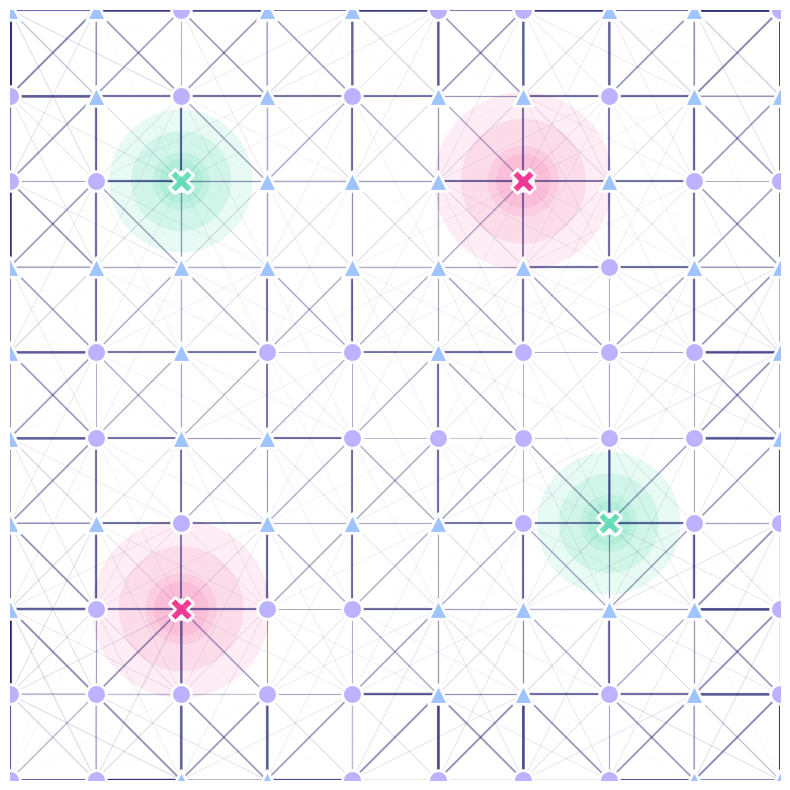

In [6]:
(lnd, logbook) = srv.optimizeTrapsGA(
    lnd, pop_size='auto', generations=1000,
    mating_params='auto', mutation_params='auto', selection_params='auto',
    fitFuns={'inner': np.sum, 'outer': np.mean}, verbose=False
)
# Exporting Plot to Disk ------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
lnd.plotSites(fig, ax, size=200)
lnd.plotTraps(fig, ax)
lnd.plotMaskedMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    os.path.join(OUT_PTH, '{}.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

<hr>

# More Information

* [MGSurvE's Extensive Continuous Optimization Tutorial](https://chipdelmal.github.io/MGSurvE/build/html/GA_STP.html)
* [MGSurvE's Continuous Optimization API entry](https://chipdelmal.github.io/MGSurvE/build/html/MGSurvE.html#MGSurvE.optimization.optimizeTrapsGA)
* [DEAP's documentation](https://deap.readthedocs.io/en/master/)
